In [1]:
%matplotlib inline

# In this notebook, you will calculate temporal patterns of metagenome-assembled genome (MAG) representation from a time series of human gut metagenomes from one individual. MAGs will be clustered based on these patterns using the K-means clustering algorithm from scikit-learn. Information like metagenome size, MAG size, and MAG coverage have already been calculated.

### Import all the dependencies

In [2]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Move to working directory

In [205]:
os.chdir('/home/manager/Desktop/Scripts/Sample_Data')

# 01. This section takes MAG coverage in each metagenome, represented by the Truncated Average Depth (TAD), and normalizes by Genome Equivalent (GE) of the metagenome. 

## Raw TAD values have been previously calculated. These values will be normalized by the GE value of the metagenome, which was calculated by the program MicrobeCensus.

### Below is an example MicrobeCensus output file

In [203]:
!cat GEs/15_1_GE.txt

Parameters
metagenome:	02.5.trimmed_fasta_split/15_1.1.fa,02.5.trimmed_fasta_split/15_1.2.fa
reads_sampled:	10000000
trimmed_length:	150
min_quality:	-5
mean_quality:	-5
filter_dups:	False
max_unknown:	100

Results
average_genome_size:	2811588.93115
total_bases:	2766955683
genome_equivalents:	984.125258264


### Function to extract the Genome Equivalent value for a metagenome from the MicrobeCensus output file

In [95]:
def extract_GE(GE):
    """Use the MicrobeCensus output file to extract the Genome Equivalent value of the metagenome"""
    with open(GE, "rt") as GE_file:
        # read all lines into a list
        lines = GE_file.readlines()
        # extract just the genome equivalent value, which is the second value on the 12th line
        ge = float(lines[12].split('\t')[1])
    return(ge)

### Navigate to the directory with all the MicrobeCensus files

In [96]:
os.chdir('GEs')

### Extract the GE values from each file

In [97]:
GE_values = {}
files = os.listdir()
for file in files:
    a, b = file.split('.')
    x = extract_GE(file)
    GE_values[a] = x

## 02. Use information about MAG and metagenome sizes, as well as GE values extracted in [01], to generate normalize TAD values and other data for each MAG in each sample.

### We need three tables: the complete MAG list, high-quality dereplicated MAG names and corresponding size, and metagenome with time point ('Day) and size in bp.

#### Navigate back to the main directory

In [207]:
os.chdir('/home/manager/Desktop/Scripts/Sample_Data')

### 02a. Import two files: one with the MAG IDs of interest (ie high-quality, dereplicated) and one with only all MAGs and their corresponding sizes. Then merge the two tables to get a data frame with estimated sizes of only the relevant MAGs.

In [208]:
mag_list = pd.read_csv("MAG_list.csv", names=["Bin"])
mag_sizes = pd.read_csv("MAG_sizes.csv")

In [210]:
mag_list.head()

,Bin
0,13_1_001
1,14_1_002
2,14_1_003
3,14_1_005
4,14_4_005


In [211]:
mag_sizes.head()

,Bin,Est_size
0,13_1_001,7953998.182
1,13_1_002,2380288.584
2,13_1_003,8476194.553
3,13_1_004,3476218.204
4,13_1_005,8417263.158


In [212]:
mag_list_sizes = mag_list.merge(mag_sizes, how='inner', on='Bin')
mag_list_sizes.head()

,Bin,Est_size
0,13_1_001,7953998.182
1,14_1_002,2982715.048
2,14_1_003,2346629.669
3,14_1_005,2952562.304
4,14_4_005,2833498.943


### Check if there are any MAGs from the list that didn't end up in the merged df with sizes

In [ ]:
mag_list[(~mag_list.Bin.isin(mag_list_sizes.Bin))]

### 02b. Import file containing each metagenome name ('Sample'), corresponding time point ('Day'), and corresponding read numbers and total base pairs.

### This file has information for several individuals over time, represented by the first number before the underscore (sample 13_1 is Individual 13, time point 1), but we will only use data from Individual 15 (see 02d).

In [213]:
mgn_bps = pd.read_csv("MGN_reads.csv")

In [214]:
mgn_bps.head()

,Sample,Day,reads,bp
0,13_1,0,7961140,1110839980
1,13_2,2,5398844,759742464
2,13_4,4,9909670,1363502990
3,15_1,0,10076061,1388074800
4,15_3,3,9470006,1285469684


### 02c. Function to append TAD table for one metagenome with data on MAG size and coverage
#### The input TAD table ('tads') should have two columns: one with MAG names and one with the corresponding raw TAD value, with no headers. GE input ('ge') should be the value corresponding to MAG name, as stored in the dictionary created above. The 'name' variable is the sample name (eg, 15_1), and 'sizes' is a table with two columns: one with MAG names and one with the corresponding sizes (ie, mag_list_sizes data frame created above). 

In [215]:
def normalize_TADs(tads, ge, name, sizes):
    """Use MAG TAD values and metagenome GE values to normalize TADs for each MAG in the metagenome"""
    ge_list = [ge] * len(tads.index)
    bps = mgn_bps.loc[mgn_bps['Sample'] == name, 'bp'].iloc[0]
    bps_list = bps * len(tads.index)
    days = mgn_bps.loc[mgn_bps['Sample'] == name, 'Day'].iloc[0]
    tads['Sample'] = name
    tads['GE'] = ge_list
    tads['mgn_bps'] = bps_list
    tads['Day'] = days
    # calculate normalized TAD value by dividing the raw TAD by the Genome Equivalent value
    tads['Normalized_TAD'] = tads['Raw_TAD'] / tads['GE'] 
    tads['MAG_size'] = sizes['Est_size']
    tads['MAG_proportion'] = (tads['Raw_TAD'] * tads['MAG_size']) / tads['mgn_bps']
    norm_output = tads[[
        'Sample','Day','GE','mgn_bps','MAG','Raw_TAD','MAG_size','Normalized_TAD','MAG_proportion'
        ]]
    return(norm_output)

### 02d. Loop through function with each metagenome in the time series for Individual 15 to generate data frame with normalized TAD and other data

#### First navigate to the 'tads_RAW' directory, which has one file for each metagenome in the time series. Each file contains raw TAD values of each MAG in that metagenome.

In [216]:
os.chdir('tads_RAW')

In [217]:
# create empty list for data frames of individual samples, which will be concatenated outside the loop
timeseries_df = [] 
# use the files in the working directory
files = os.listdir() 
for file in files:
    tads_file = pd.read_csv(file, names=["MAG","Raw_TAD"])
    # The first part of the file name is our sample (metagenome) name
    sample, ext = file.split('-')
    x = '%s_GE' % sample
    y = '%s' % sample
    # print(x, GE_values[x], y)
    df = normalize_TADs(tads_file, GE_values[x], y, mag_list_sizes)
    #print(df.head(5))
    timeseries_df.append(df)

### Concatenate all the dataframes in the list timeseries_df

In [218]:
timeseries_df = pd.concat(timeseries_df)
timeseries_df.head()

,Sample,Day,GE,mgn_bps,MAG,Raw_TAD,MAG_size,Normalized_TAD,MAG_proportion
0,15_8,22,981.13545,88410340775,13_1_001,9.123320,7953998.182,0.009299,0.000821
1,15_8,22,981.13545,88410340775,14_1_002,0.557976,2982715.048,0.000569,0.000019
2,15_8,22,981.13545,88410340775,14_1_003,0.000000,2346629.669,0.000000,0.000000
3,15_8,22,981.13545,88410340775,14_1_005,0.000000,2952562.304,0.000000,0.000000
4,15_8,22,981.13545,88410340775,14_4_005,1.490583,2833498.943,0.001519,0.000048


## 03. This section analyzes the temporal pattern of each MAG over the time course and clusters MAGs based on similar patterns using normalized TAD values at each time point and the k-means clustering algorithm.

### 03a. We compiled a lot of data for each sample and MAG in [02], but we only need a subset to analyze temporal patterns. So, first we select the relevant columns from the data frame.

In [219]:
df_for_kmeans = timeseries_df[['Day','MAG','Normalized_TAD']]
df_for_kmeans.head()

,Day,MAG,Normalized_TAD
0,22,13_1_001,0.009299
1,22,14_1_002,0.000569
2,22,14_1_003,0.000000
3,22,14_1_005,0.000000
4,22,14_4_005,0.001519


### 03b. Plot the time series to get a sense of magnitude and pattern of change over time

Text(0.5, 1.0, 'Normalized TADs Over Time')

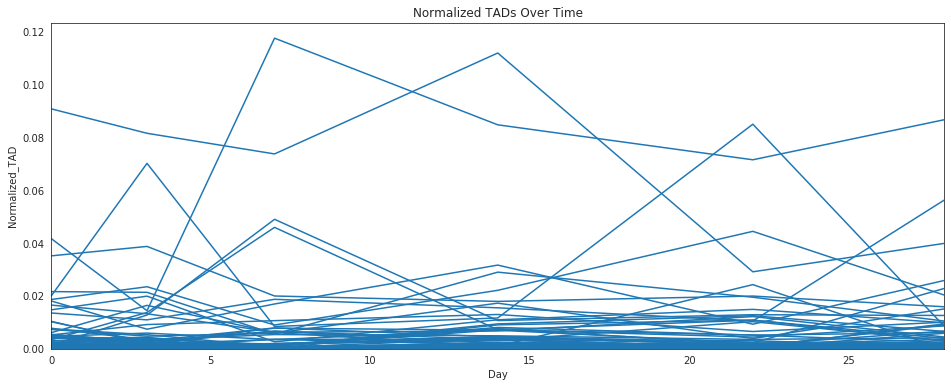

In [220]:
plt.figure(figsize=(16, 6))
sns.lineplot(
    x="Day", y="Normalized_TAD", units="MAG", data=df_for_kmeans, estimator=None, legend=False)
plt.xlim(min(df_for_kmeans.Day), max(df_for_kmeans.Day))
plt.ylim(min(df_for_kmeans.Normalized_TAD), None)
plt.title('Normalized TADs Over Time')

## Looks like there might be some patterns in here, but differences in TAD magnitude make them hard to visualize. Let's see if we can cluster MAGs based on similar temporal trends  using the unsupervised K-means clustering method implemented in scikit-learn.

### 03c. Format data

### Check for missing values, because they will be a problem for the transformation and clustering

In [221]:
print(df_for_kmeans.isna().sum())

Day               0
MAG               0
Normalized_TAD    0
dtype: int64


### Reshape the data frame so we can just work with the normalized TAD values (the "features")

In [222]:
df = df_for_kmeans.pivot(index='MAG', columns='Day')
df.head()

Normalized_TAD                                                  
Day                  0         3         7         14        22        28
MAG                                                                      
13_1_001       0.018062  0.007402  0.016936  0.031634  0.009299  0.025807
14_1_002       0.000378  0.000153  0.001026  0.000837  0.000569  0.000845
14_1_003       0.000000  0.000000  0.000016  0.000000  0.000000  0.000000
14_1_005       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
14_4_005       0.005431  0.002688  0.006657  0.002239  0.001519  0.000725

### Generate an array of the values and sanity check for numbers ('float64') if desired

In [223]:
kmeans_array = df.values
# print(kmeans_array.dtype)
# print(kmeans_array)

### 03d. Standardize the features using scikit-learn "StandardScaler" function, which standardizes values by removing the mean and scaling to unit variance, and define the target labels.

In [224]:
x = StandardScaler().fit_transform(kmeans_array)
x

array([[ 8.94072976e-01,  7.12438006e-02,  5.49688812e-01,
         1.38382521e+00,  1.62598387e-01,  1.41149709e+00],
       [-4.61749235e-01, -4.45317473e-01, -3.23371574e-01,
        -3.85447178e-01, -4.25999281e-01, -4.10737257e-01],
       [-4.90708807e-01, -4.56255344e-01, -3.78805787e-01,
        -4.33539895e-01, -4.64342582e-01, -4.72438389e-01],
       [-4.90708807e-01, -4.56255344e-01, -3.79665373e-01,
        -4.33539895e-01, -4.64342582e-01, -4.72438389e-01],
       [-7.43354721e-02, -2.64686639e-01, -1.43466387e-02,
        -3.04914380e-01, -3.61911947e-01, -4.19494623e-01],
       [-4.37244656e-01, -3.90198004e-01, -3.42965129e-01,
        -4.19065262e-01, -4.32362884e-01, -4.51270851e-01],
       [ 7.75123221e-01,  4.86973186e-01, -3.52217116e-02,
        -4.68404010e-02,  3.56393568e-01, -1.46357627e-01],
       [ 2.91763037e-01, -2.78775620e-01, -2.77993919e-01,
        -1.66808046e-01, -2.95278917e-01, -2.97340219e-01],
       [ 3.04922257e-01, -3.20369293e-01,  4.914

### Define the targets as the MAGs

In [225]:
y = pd.Series(df.index)

# 04. Principal Components Analysis and K-means clustering

### 04a. First generate a PCA to reduce dimensionality

In [226]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [227]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [228]:
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,MAG
0,1.879665,-0.902160,13_1_001
1,-0.997884,-0.099338,14_1_002
2,-1.097659,-0.061880,14_1_003
3,-1.098012,-0.061520,14_1_005
4,-0.576587,-0.035719,14_4_005


### Visualize the contribution of each principal component to total variance

([<matplotlib.axis.XTick at 0x7fbe7f1cc780>,
 <a list of 2 Text xticklabel objects>)

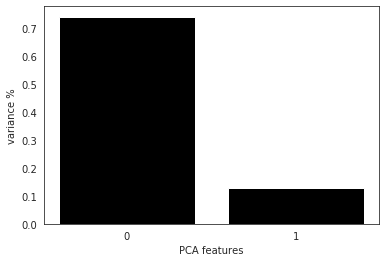

In [229]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

### Plot PCA where each point is a MAG

Text(0, 0.5, 'PCA 2')

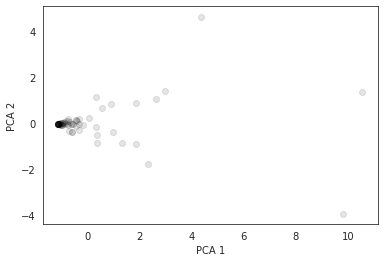

In [230]:
PCA_components = pd.DataFrame(principalComponents)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

## 04b. K-means clustering

### Determine levels of inertia as a function of cluster number

In [231]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

In [232]:
inertias

[350.34640542612715,
 133.2579511492458,
 67.12397429798082,
 42.517500459000814,
 28.335125723037308,
 17.426266962199804,
 10.601480151337611,
 7.413672741415341,
 4.511421154337272]

### Determine how many clusters are most informative. Once the line starts to level out, more clusters become less useful.

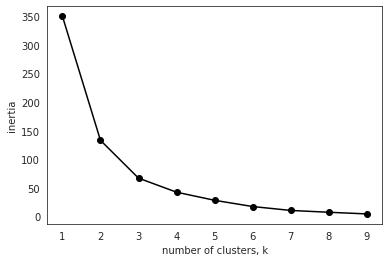

In [233]:
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### Initialize k-means using ideal number of clusters. I decided to use 6 clusters in this case.

In [234]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(principalDf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Determine the centroids of each cluster

In [235]:
labels = kmeans.predict(principalDf)
centroids = kmeans.cluster_centers_
centroids

array([[-0.81853918, -0.04825301],
       [10.55821541,  1.3548933 ],
       [ 4.35423608,  4.63376339],
       [ 1.55559309,  0.99094764],
       [ 9.80070917, -3.94923207],
       [ 1.09982558, -0.78917244]])

### Plot the clusters with the centroids marked by (*)

Text(0.5, 1.0, '15 MAG K-means')

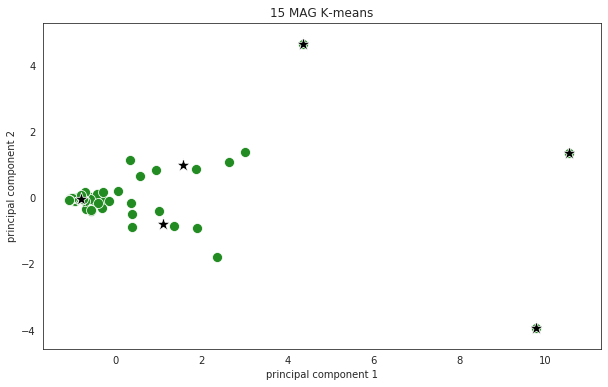

In [236]:
plt.figure(figsize=(10, 6))
sns.set_style("white")
sns.scatterplot(finalDf.iloc[:, 0], finalDf.iloc[:, 1], s=100, color="forestgreen")
sns.scatterplot(centroids[ :, 0], centroids[ :, 1], marker='*', s=200, color="black")
plt.title('15 MAG K-means')

## Looks like there aren't really distinct clusters of MAGs based on similar time series values. However, there are some individual MAGs that are differentiated from most of the others. It might be worth scaling or standardizing the data in a different way. For now, we can still extract the centroid points as they might be useful for identifying those three outlier MAGs. 

### Extract points of each cluster

In [237]:
#Labels of each point
kmeans.labels_

array([5, 0, 0, 0, 0, 0, 3, 0, 5, 0, 3, 3, 3, 4, 5, 5, 1, 2, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

### Get the indices of the points for each corresponding cluster

In [238]:
points = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
points

{0: array([ 1,  2,  3,  4,  5,  7,  9, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 47, 49, 50, 51, 52, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 1: array([16]),
 2: array([17]),
 3: array([ 6, 10, 11, 12, 18, 48]),
 4: array([13]),
 5: array([ 0,  8, 14, 15, 54, 55, 56])}

### Save cluster lists

In [115]:
# pd.DataFrame.from_dict(data=points, orient='index').to_csv('15-kmeans-cluster-6.csv', header=False)

### If you got this far, thank you! Please let me know if you have any questions, and keep your eyes one for a study using this script to analyze human gut microbiomes infected with Norovirus.